In [1]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
from functions_pbp import get_lead_timeline
from functions_pbp import create_home_delta_plot
from functions_pbp import get_all_nba_games
from functions_pbp import get_starting_lineup
from functions_pbp import get_lineup_log
from nba_api.stats.endpoints import playbyplayv2
from nba_api.stats.endpoints import boxscoretraditionalv2
from nba_api.stats.endpoints import leaguegamelog
import numpy as np

In [2]:
df = get_all_nba_games(2022)
GAME_ID = df['GAME_ID'].values[0]
HOMETEAM_ID = df['HOMETEAM_ID'].values[0]
AWAYTEAM_ID = df['AWAYTEAM_ID'].values[0]

lead_timeline_df = get_lead_timeline(GAME_ID)
lineup_df = get_lineup_log(GAME_ID, HOMETEAM_ID, AWAYTEAM_ID)

/Users/eduardogarcia/Documents/GitHub/playbyplay/functions_pbp.py:120: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['HomeScore'] = merged_df['HomeScore'].fillna(method='bfill')
/Users/eduardogarcia/Documents/GitHub/playbyplay/functions_pbp.py:121: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['AwayScore'] = merged_df['AwayScore'].fillna(method='bfill')
/Users/eduardogarcia/Documents/GitHub/playbyplay/functions_pbp.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['HomeDif'].iloc[0] = merged_df['HomeDelta'].iloc[0]
/Users/eduardogarcia/Documents/GitHub/playbyplay/functions_pbp.py:130: SettingWi

In [28]:
HOME_STARTING_LINEUP = get_starting_lineup(GAME_ID, HOMETEAM_ID)
HOME_STARTING_LINEUP.insert(0,HOMETEAM_ID)
HOME_STARTING_LINEUP.insert(1,1)
HOME_STARTING_LINEUP.insert(2,"12:00")

AWAY_STARTING_LINEUP = get_starting_lineup(GAME_ID, AWAYTEAM_ID)
AWAY_STARTING_LINEUP.insert(0,AWAYTEAM_ID)
AWAY_STARTING_LINEUP.insert(1,1)
AWAY_STARTING_LINEUP.insert(2,"12:00")

boxscore = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=GAME_ID)
boxscore_df = boxscore.get_data_frames()[0]

playbyplay = playbyplayv2.PlayByPlayV2(game_id=GAME_ID)
playbyplay_df = playbyplay.get_data_frames()[0]

DESCRIPTION_STRING = ["HOMEDESCRIPTION", "VISITORDESCRIPTION"]
TEAMS_ID = [HOMETEAM_ID, AWAYTEAM_ID]
STARTING_LINEUP = [HOME_STARTING_LINEUP, AWAY_STARTING_LINEUP]

lineup_df = pd.DataFrame(columns=['TEAM_ID','PERIOD','PCTIMESTRING','PLAYER1','PLAYER2','PLAYER3','PLAYER4','PLAYER5'])

for j, team_description in enumerate(DESCRIPTION_STRING[0:1]):
    lineup_df.loc[len(lineup_df)] = STARTING_LINEUP[j]
    substitutions_log = playbyplay_df[playbyplay_df[team_description].str.contains('sub', case=False)&
                                    playbyplay_df[team_description].notna()
                                    ]
    substitutions_log['TEAM_ID'] = TEAMS_ID[j]

    substitutions_log = substitutions_log[['TEAM_ID','PERIOD','PCTIMESTRING',team_description,
                                        'PLAYER1_ID','PLAYER1_NAME','PLAYER2_ID','PLAYER2_NAME']]
    
    substitutions_log = substitutions_log.reset_index(drop=True)
    print(substitutions_log.shape)

    for i in range(0,len(substitutions_log)):
        PERIOD_SUB = substitutions_log['PERIOD'].values[i]
        PCTIMESTRING_SUB = substitutions_log['PCTIMESTRING'].values[i]
        player_out = substitutions_log['PLAYER1_ID'].values[i]
        player_in  = substitutions_log['PLAYER2_ID'].values[i]
        
        previous_lineup = list(lineup_df.loc[len(lineup_df)-1].values)
        new_lineup = previous_lineup
        new_lineup[0] = TEAMS_ID[j]
        new_lineup[1] = PERIOD_SUB
        new_lineup[2] = PCTIMESTRING_SUB
        new_lineup = [player_in if x == player_out else x for x in new_lineup]
        lineup_df.loc[len(lineup_df)] = new_lineup

        # idx = lineup_df.groupby(['TEAM_ID','PERIOD', 'PCTIMESTRING'])['PLAYER1'].idxmax()
        # lineup_df = lineup_df.loc[idx].sort_index().reset_index(drop=True)
        lineup_df['PCTIMESTRING']= lineup_df['PCTIMESTRING'].apply(lambda x: ':'.join(part.zfill(2) for part in x.split(':')))
        lineup_df = lineup_df.sort_values(by=['TEAM_ID','PERIOD','PCTIMESTRING'], ascending=[False,True, False]).reset_index(drop=True)
    print(lineup_df.shape)

lineup_df

(25, 8)
(26, 8)


/var/folders/mv/mkg__7515n9dswqmhcq_vz980000gn/T/ipykernel_51873/1304506665.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  substitutions_log['TEAM_ID'] = TEAMS_ID[j]


,TEAM_ID,PERIOD,PCTIMESTRING,PLAYER1,PLAYER2,PLAYER3,PLAYER4,PLAYER5
0,1610612738,1,12:00,1627759,1628369,201143,1628401,203935
1,1610612738,1,08:24,1627759,1628369,203943,1628401,203935
2,1610612738,1,06:41,1627759,1628369,203943,1629684,203935
3,1610612738,1,05:10,1627759,1627763,203943,1629684,203935
4,1610612738,1,03:39,1627759,1627763,201933,1629684,203935
5,1610612738,1,02:51,1628369,1627763,201933,1629684,203935
6,1610612738,1,02:51,1628369,1627763,201933,1629684,1628401
7,1610612738,1,00:01,1628369,1627763,203935,1629684,1628401
8,1610612738,2,10:12,1628369,1627763,203935,203943,1628401
9,1610612738,2,09:33,1628369,1627763,203935,203943,1627759


In [24]:
substitutions_log[0:12]

,TEAM_ID,PERIOD,PCTIMESTRING,HOMEDESCRIPTION,PLAYER1_ID,PLAYER1_NAME,PLAYER2_ID,PLAYER2_NAME
0,1610612738,1,8:24,SUB: Vonleh FOR Horford,201143,Al Horford,203943,Noah Vonleh
1,1610612738,1,6:41,SUB: Williams FOR White,1628401,Derrick White,1629684,Grant Williams
2,1610612738,1,5:10,SUB: Brogdon FOR Tatum,1628369,Jayson Tatum,1627763,Malcolm Brogdon
3,1610612738,1,3:39,SUB: Griffin FOR Vonleh,203943,Noah Vonleh,201933,Blake Griffin
4,1610612738,1,2:51,SUB: Tatum FOR Brown,1627759,Jaylen Brown,1628369,Jayson Tatum
5,1610612738,1,2:51,SUB: White FOR Smart,203935,Marcus Smart,1628401,Derrick White
6,1610612738,1,0:01,SUB: Smart FOR Griffin,201933,Blake Griffin,203935,Marcus Smart
7,1610612738,2,10:12,SUB: Vonleh FOR Williams,1629684,Grant Williams,203943,Noah Vonleh
8,1610612738,2,9:33,SUB: Brown FOR White,1628401,Derrick White,1627759,Jaylen Brown
9,1610612738,2,8:20,SUB: Smart FOR Tatum,1628369,Jayson Tatum,203935,Marcus Smart


In [16]:
lineup_df.loc[lineup_df['TEAM_ID']==1610612755][0:5]

,TEAM_ID,PERIOD,PCTIMESTRING,PLAYER1,PLAYER2,PLAYER3,PLAYER4,PLAYER5
0,1610612755,1,12:00,202699,200782,203954,1630178,201935
1,1610612755,1,05:10,202699,200782,1626149,1630178,201935
2,1610612755,1,03:39,203935,201143,203935,203935,1628369
3,1610612755,1,02:51,203935,201143,203935,203935,1628369
4,1610612755,1,00:21,203935,201143,203935,203935,1628369


In [13]:
substitutions_log[0:5]

,TEAM_ID,PERIOD,PCTIMESTRING,VISITORDESCRIPTION,PLAYER1_ID,PLAYER1_NAME,PLAYER2_ID,PLAYER2_NAME
0,1610612755,1,5:10,SUB: Harrell FOR Embiid,203954,Joel Embiid,1626149,Montrezl Harrell
1,1610612755,1,3:39,SUB: Melton FOR Maxey,1630178,Tyrese Maxey,1629001,De'Anthony Melton
2,1610612755,1,3:39,SUB: House Jr. FOR Tucker,200782,P.J. Tucker,1627863,Danuel House Jr.
3,1610612755,1,2:51,SUB: Niang FOR Harris,202699,Tobias Harris,1627777,Georges Niang
4,1610612755,1,0:21,SUB: Thybulle FOR Niang,1627777,Georges Niang,1629680,Matisse Thybulle


In [ ]:
HOME_STARTING_LINEUP = get_starting_lineup(GAME_ID, HOMETEAM_ID)
HOME_STARTING_LINEUP.insert(0,HOMETEAM_ID)
HOME_STARTING_LINEUP.insert(1,1)
HOME_STARTING_LINEUP.insert(2,"12:00")

AWAY_STARTING_LINEUP = get_starting_lineup(GAME_ID, AWAYTEAM_ID)
AWAY_STARTING_LINEUP.insert(0,AWAYTEAM_ID)
AWAY_STARTING_LINEUP.insert(1,1)
AWAY_STARTING_LINEUP.insert(2,"12:00")

boxscore = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=GAME_ID)
boxscore_df = boxscore.get_data_frames()[0]

playbyplay = playbyplayv2.PlayByPlayV2(game_id=GAME_ID)
playbyplay_df = playbyplay.get_data_frames()[0]

DESCRIPTION_STRING = ["HOMEDESCRIPTION", "VISITORDESCRIPTION"]
TEAMS_ID = [HOMETEAM_ID, AWAYTEAM_ID]
STARTING_LINEUP = [HOME_STARTING_LINEUP, AWAY_STARTING_LINEUP]

lineup_df = pd.DataFrame(columns=['TEAM_ID','PERIOD','PCTIMESTRING','PLAYER1','PLAYER2','PLAYER3','PLAYER4','PLAYER5'])

for j, team_description in enumerate(DESCRIPTION_STRING):
    lineup_df.loc[len(lineup_df)] = STARTING_LINEUP[j]
    substitutions_log = playbyplay_df[playbyplay_df[team_description].str.contains('sub', case=False)&
                                    playbyplay_df[team_description].notna()
                                    ]
    substitutions_log['TEAM_ID'] = TEAMS_ID[j]

    substitutions_log = substitutions_log[['TEAM_ID','PERIOD','PCTIMESTRING',team_description,
                                        'PLAYER1_ID','PLAYER1_NAME','PLAYER2_ID','PLAYER2_NAME']]
    substitutions_log = substitutions_log.reset_index(drop=True)

    for i in range(0,len(substitutions_log)):
        PERIOD_SUB = substitutions_log['PERIOD'].values[i]
        PCTIMESTRING_SUB = substitutions_log['PCTIMESTRING'].values[i]
        player_out = substitutions_log['PLAYER1_ID'].values[i]
        player_in  = substitutions_log['PLAYER2_ID'].values[i]
        
        previous_lineup = list(lineup_df.loc[len(lineup_df)-1].values)
        new_lineup = previous_lineup
        new_lineup[0] = TEAMS_ID[j]
        new_lineup[1] = PERIOD_SUB
        new_lineup[2] = PCTIMESTRING_SUB
        new_lineup = [player_in if x == player_out else x for x in new_lineup]
        lineup_df.loc[len(lineup_df)] = new_lineup

        idx = lineup_df.groupby(['TEAM_ID','PERIOD', 'PCTIMESTRING'])['PLAYER1'].idxmax()
        lineup_df = lineup_df.loc[idx].sort_index().reset_index(drop=True)
        lineup_df['PCTIMESTRING']= lineup_df['PCTIMESTRING'].apply(lambda x: ':'.join(part.zfill(2) for part in x.split(':')))
        lineup_df = lineup_df.sort_values(by=['TEAM_ID','PERIOD','PCTIMESTRING'], ascending=[False,True, False]).reset_index(drop=True)

lineup_df

In [26]:
for i in range(0,len(substitutions_log)):
        PERIOD_SUB = substitutions_log['PERIOD'].values[i]
        PCTIMESTRING_SUB = substitutions_log['PCTIMESTRING'].values[i]
        player_out = substitutions_log['PLAYER1_ID'].values[i]
        player_in  = substitutions_log['PLAYER2_ID'].values[i]
        
        previous_lineup = list(lineup_df.loc[len(lineup_df)-1].values)
        new_lineup = previous_lineup
        new_lineup[0] = TEAMS_ID[j]
        new_lineup[1] = PERIOD_SUB
        new_lineup[2] = PCTIMESTRING_SUB
        new_lineup = [player_in if x == player_out else x for x in new_lineup]
        lineup_df.loc[len(lineup_df)] = new_lineup

        idx = lineup_df.groupby(['TEAM_ID','PERIOD', 'PCTIMESTRING'])['PLAYER1'].idxmax()
        clean_lineup_df = lineup_df.loc[idx].sort_index().reset_index(drop=True)
        clean_lineup_df['PCTIMESTRING']= clean_lineup_df['PCTIMESTRING'].apply(lambda x: ':'.join(part.zfill(2) for part in x.split(':')))
        clean_lineup_df = clean_lineup_df.sort_values(by=['TEAM_ID','PERIOD','PCTIMESTRING'], ascending=[False,True, False]).reset_index(drop=True)

clean_lineup_df

,TEAM_ID,PERIOD,PCTIMESTRING,PLAYER1,PLAYER2,PLAYER3,PLAYER4,PLAYER5
0,1610612755,1,12:00,202699,200782,203954,1630178,201935
1,1610612738,1,12:00,1627759,1628369,201143,1628401,203935
2,1610612738,1,05:10,1627759,1628369,201143,1628401,203935
3,1610612738,1,03:39,1627759,1628369,201143,1628401,203935
4,1610612738,1,02:51,1627759,1628369,201143,1628401,203935
5,1610612738,1,00:21,1627759,1628369,201143,1628401,203935
6,1610612738,1,00:01,1627759,1628369,201143,1628401,203935
7,1610612738,2,09:33,1627759,1628369,201143,1628401,203935
8,1610612738,2,08:20,1627759,1628369,201143,1628401,203935
9,1610612738,2,07:12,1627759,1628369,201143,1628401,203935


In [14]:
lineup_df.loc[lineup_df['TEAM_ID']==HOMETEAM_ID]

,TEAM_ID,PERIOD,PCTIMESTRING,PLAYER1,PLAYER2,PLAYER3,PLAYER4,PLAYER5
0,1610612755,1,12:00,202699,200782,203954,1630178,201935
1,1610612755,1,08:24,202699,200782,203954,1630178,201935
2,1610612755,1,06:41,202699,200782,203954,1630178,201935
3,1610612755,1,05:10,202699,200782,203954,1630178,201935
4,1610612755,1,03:39,202699,200782,203954,1630178,201935
5,1610612755,1,02:51,202699,200782,203954,1630178,201935
6,1610612755,1,00:01,202699,200782,203954,1630178,201935
7,1610612755,2,10:12,202699,200782,203954,1630178,201935
8,1610612755,2,09:33,202699,200782,203954,1630178,201935
9,1610612755,2,08:20,202699,200782,203954,1630178,201935


In [12]:
get_starting_lineup(GAME_ID,HOMETEAM_ID)

[202699, 200782, 203954, 1630178, 201935]

In [13]:
streak_lineup_df = lineup_df.loc[lineup_df['TEAM_ID']==HOMETEAM_ID].reset_index(drop=True)
starting_lineup = get_starting_lineup(GAME_ID,HOMETEAM_ID)

streak_lineup_df['Starters_In_Lineup'] = streak_lineup_df[['PLAYER1', 'PLAYER2', 'PLAYER3', 'PLAYER4', 'PLAYER5']].apply(
    lambda row: sum(1 for element in row if element in starting_lineup[2:]), axis=1)

streak_lineup_df

,TEAM_ID,PERIOD,PCTIMESTRING,PLAYER1,PLAYER2,PLAYER3,PLAYER4,PLAYER5,Starters_In_Lineup
0,1610612755,1,12:00,202699,200782,203954,1630178,201935,3
1,1610612755,1,08:24,202699,200782,203954,1630178,201935,3
2,1610612755,1,06:41,202699,200782,203954,1630178,201935,3
3,1610612755,1,05:10,202699,200782,203954,1630178,201935,3
4,1610612755,1,03:39,202699,200782,203954,1630178,201935,3
5,1610612755,1,02:51,202699,200782,203954,1630178,201935,3
6,1610612755,1,00:01,202699,200782,203954,1630178,201935,3
7,1610612755,2,10:12,202699,200782,203954,1630178,201935,3
8,1610612755,2,09:33,202699,200782,203954,1630178,201935,3
9,1610612755,2,08:20,202699,200782,203954,1630178,201935,3


In [7]:

streak_lineup_df = streak_lineup_df.merge(lineup_summary[['LineUp','LineUp_Order']], on='LineUp')
streak_lineup_df = streak_lineup_df.reset_index()
streak_lineup_df = streak_lineup_df.rename(columns={'index':'seconds_in_game'})
streak_lineup_df['seconds_in_game'] = streak_lineup_df['seconds_in_game']+1
streak_lineup_df


# Create a new column to count the matching elements
streak_lineup_df['Starters_In_Lineup'] = streak_lineup_df[['PLAYER1', 'PLAYER2', 'PLAYER3', 'PLAYER4', 'PLAYER5']].apply(
    lambda row: sum(1 for element in row if element in starting_lineup[2:]), axis=1)

# Calculate the percentage of matching elements
streak_lineup_df['Starters_Percentage'] = (streak_lineup_df['Starters_In_Lineup'] /len(starting_lineup[2:]))
streak_lineup_df

,PERIOD,PCTIMESTRING,HomeDelta,HomeDif,AwayDelta,AwayDif,TotalPoints
0,1,12:00,-2.0,-2.0,2.0,2.0,2.0
1,1,11:59,-2.0,0.0,2.0,0.0,2.0
2,1,11:58,-2.0,0.0,2.0,0.0,2.0
3,1,11:57,-2.0,0.0,2.0,0.0,2.0
4,1,11:56,-2.0,0.0,2.0,0.0,2.0
...,...,...,...,...,...,...,...
2879,4,00:04,-9.0,0.0,9.0,0.0,243.0
2880,4,00:03,-9.0,0.0,9.0,0.0,243.0
2881,4,00:02,-9.0,0.0,9.0,0.0,243.0
2882,4,00:01,-9.0,0.0,9.0,0.0,243.0


In [ ]:
streak_lineup_df = lead_timeline_df.merge(lineup_df, how='left', on=['PERIOD','PCTIMESTRING'])

In [6]:
columns_to_convert = lineup_df.columns.values[-5:].tolist()
columns_to_convert

['PLAYER1', 'PLAYER2', 'PLAYER3', 'PLAYER4', 'PLAYER5']

In [ ]:
streak_lineup_df[columns_to_convert] = streak_lineup_df[columns_to_convert].fillna(method='ffill')

streak_lineup_df[columns_to_convert] = streak_lineup_df[columns_to_convert].astype('int')

streak_lineup_df['LineUp'] = streak_lineup_df[columns_to_convert].apply(lambda row: ', '.join(str(x) for x in sorted(row.dropna())), axis=1)

streak_lineup_df

In [30]:
# Initialize an empty list to store game data
all_games = []

# Specify the range of seasons you want to cover
# For example, from the 1946-47 season to the 2020-21 season
season_str = f"{2022}-{str(2022+1)[-2:]}"
# print(f"Fetching games for season: {season_str}")

for game_type in ["Playoffs","Regular Season"]:
    # Fetch the game logs for the season
    game_log = leaguegamelog.LeagueGameLog(season=season_str,season_type_all_star=game_type)
    games = game_log.get_data_frames()[0]

    # Append the data to the all_games list
    all_games.append(games)

    # Combine all seasons into a single DataFrame
    all_games_df = pd.concat(all_games, ignore_index=True)
    all_games_df = all_games_df[['GAME_ID',	'GAME_DATE', 'MATCHUP',	'TEAM_ID']]
    all_games_df = all_games_df.sort_values(by=['GAME_DATE','GAME_ID'])
all_games_df

,GAME_ID,GAME_DATE,MATCHUP,TEAM_ID
170,0022200001,2022-10-18,PHI @ BOS,1610612755
171,0022200001,2022-10-18,BOS vs. PHI,1610612738
168,0022200002,2022-10-18,GSW vs. LAL,1610612744
169,0022200002,2022-10-18,LAL @ GSW,1610612747
190,0022200003,2022-10-19,DET vs. ORL,1610612765
...,...,...,...,...
163,0042200403,2023-06-07,MIA vs. DEN,1610612748
164,0042200404,2023-06-09,MIA vs. DEN,1610612748
165,0042200404,2023-06-09,DEN @ MIA,1610612743
166,0042200405,2023-06-12,MIA @ DEN,1610612748


In [37]:
# Initialize an empty list to store game data
all_games = []

# Specify the range of seasons you want to cover
# For example, from the 1946-47 season to the 2020-21 season
season_str = f"{2022}-{str(2022+1)[-2:]}"
# print(f"Fetching games for season: {season_str}")

for game_type in ["Playoffs","Regular Season"]:
    # Fetch the game logs for the season
    game_log = leaguegamelog.LeagueGameLog(season=season_str,season_type_all_star=game_type)
    games = game_log.get_data_frames()[0]

    # Append the data to the all_games list
    all_games.append(games)

    # Combine all seasons into a single DataFrame
    all_games_df = pd.concat(all_games, ignore_index=True)
    all_games_df = all_games_df[['GAME_ID',	'GAME_DATE', 'MATCHUP',	'TEAM_ID']]
    all_games_df = all_games_df.sort_values(by=['GAME_DATE','GAME_ID'])

    # Identifying the home and away teams.
    home_team_row = all_games_df[all_games_df['MATCHUP'].str.contains('@')]
    away_team_row = all_games_df[~all_games_df['MATCHUP'].str.contains('@')]

    # Constructing the target DataFrame.
    target_state_data = {
        'GAME_ID': home_team_row['GAME_ID'].values,
        'GAME_DATE': home_team_row['GAME_DATE'].values,
        'MATCHUP': home_team_row['MATCHUP'].str.replace('@', 'vs.').str.strip(),
        'HOMETEAM_ID': home_team_row['TEAM_ID'].values,
        'AWAYTEAM_ID': away_team_row['TEAM_ID'].values
    }

    # Creating the DataFrame for the target state.
    target_df = pd.DataFrame(target_state_data)

target_df

,GAME_ID,GAME_DATE,MATCHUP,HOMETEAM_ID,AWAYTEAM_ID
170,0022200001,2022-10-18,PHI vs. BOS,1610612755,1610612738
169,0022200002,2022-10-18,LAL vs. GSW,1610612747,1610612744
191,0022200003,2022-10-19,ORL vs. DET,1610612753,1610612765
192,0022200004,2022-10-19,WAS vs. IND,1610612764,1610612754
175,0022200005,2022-10-19,HOU vs. ATL,1610612745,1610612737
...,...,...,...,...,...
159,0042200401,2023-06-01,MIA vs. DEN,1610612748,1610612743
161,0042200402,2023-06-04,MIA vs. DEN,1610612748,1610612743
162,0042200403,2023-06-07,DEN vs. MIA,1610612743,1610612748
165,0042200404,2023-06-09,DEN vs. MIA,1610612743,1610612748


In [39]:


HOME_STARTING_LINEUP = get_starting_lineup(GAME_ID, HOMETEAM_ID)
HOME_STARTING_LINEUP.insert(0,HOMETEAM_ID)
HOME_STARTING_LINEUP.insert(1,1)
HOME_STARTING_LINEUP.insert(2,"12:00")

AWAY_STARTING_LINEUP = get_starting_lineup(GAME_ID, AWAYTEAM_ID)
AWAY_STARTING_LINEUP.insert(0,AWAYTEAM_ID)
AWAY_STARTING_LINEUP.insert(1,1)
AWAY_STARTING_LINEUP.insert(2,"12:00")

boxscore = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=GAME_ID)
boxscore_df = boxscore.get_data_frames()[0]

playbyplay = playbyplayv2.PlayByPlayV2(game_id=GAME_ID)
playbyplay_df = playbyplay.get_data_frames()[0]

DESCRIPTION_STRING = ["HOMEDESCRIPTION", "VISITORDESCRIPTION"]
TEAMS_ID = [HOMETEAM_ID, AWAYTEAM_ID]
STARTING_LINEUP = [HOME_STARTING_LINEUP, AWAY_STARTING_LINEUP]

lineup_df = pd.DataFrame(columns=['TEAM_ID','PERIOD','PCTIMESTRING','PLAYER1','PLAYER2','PLAYER3','PLAYER4','PLAYER5'])

for j, team_description in enumerate(DESCRIPTION_STRING):
    lineup_df.loc[len(lineup_df)] = STARTING_LINEUP[j]
    substitutions_log = playbyplay_df[playbyplay_df[team_description].str.contains('sub', case=False)&
                                    playbyplay_df[team_description].notna()
                                    ]
    substitutions_log['TEAM_ID'] = TEAMS_ID[j]

    substitutions_log = substitutions_log[['TEAM_ID','PERIOD','PCTIMESTRING',team_description,
                                          'PLAYER1_ID','PLAYER1_NAME','PLAYER2_ID','PLAYER2_NAME']]
    substitutions_log = substitutions_log.reset_index(drop=True)


# substitutions_log
    for i in range(0,len(substitutions_log)):
        PERIOD_SUB = substitutions_log['PERIOD'].values[i]
        PCTIMESTRING_SUB = substitutions_log['PCTIMESTRING'].values[i]
        player_out = substitutions_log['PLAYER1_ID'].values[i]
        player_in  = substitutions_log['PLAYER2_ID'].values[i]
        
        previous_lineup = list(lineup_df.loc[len(lineup_df)-1].values)
        new_lineup = previous_lineup
        new_lineup[0] = TEAMS_ID[j]
        new_lineup[1] = PERIOD_SUB
        new_lineup[2] = PCTIMESTRING_SUB
        new_lineup = [player_in if x == player_out else x for x in new_lineup]
        lineup_df.loc[len(lineup_df)] = new_lineup

        idx = lineup_df.groupby(['TEAM_ID','PERIOD', 'PCTIMESTRING'])['PLAYER1'].idxmax()
        clean_lineup_df = lineup_df.loc[idx].sort_index().reset_index(drop=True)
        clean_lineup_df['PCTIMESTRING']= clean_lineup_df['PCTIMESTRING'].apply(lambda x: ':'.join(part.zfill(2) for part in x.split(':')))

# clean_lineup_df = clean_lineup_df.sort_values(by=['PERIOD','PCTIMESTRING'], ascending=[True, False]).reset_index(drop=True)
clean_lineup_df

/var/folders/mv/mkg__7515n9dswqmhcq_vz980000gn/T/ipykernel_45094/3532002104.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  substitutions_log['TEAM_ID'] = TEAMS_ID[j]
/var/folders/mv/mkg__7515n9dswqmhcq_vz980000gn/T/ipykernel_45094/3532002104.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  substitutions_log['TEAM_ID'] = TEAMS_ID[j]


,TEAM_ID,PERIOD,PCTIMESTRING,PLAYER1,PLAYER2,PLAYER3,PLAYER4,PLAYER5
0,1610612755,1,12:00,202699,200782,203954,1630178,201935
1,1610612755,1,08:24,202699,200782,203954,1630178,201935
2,1610612755,1,06:41,202699,200782,203954,1630178,201935
3,1610612755,1,05:10,202699,200782,203954,1630178,201935
4,1610612755,1,03:39,202699,200782,203954,1630178,201935
5,1610612755,1,02:51,202699,200782,203954,1630178,201935
6,1610612755,1,00:01,202699,200782,203954,1630178,201935
7,1610612755,2,10:12,202699,200782,203954,1630178,201935
8,1610612755,2,09:33,202699,200782,203954,1630178,201935
9,1610612755,2,08:20,202699,200782,203954,1630178,201935


In [14]:

    
    for i in range(0,len(substitutions_log)):
        PERIOD_SUB = substitutions_log['PERIOD'].values[i]
        PCTIMESTRING_SUB = substitutions_log['PCTIMESTRING'].values[i]
        player_out = substitutions_log['PLAYER1_ID'].values[i]
        player_in  = substitutions_log['PLAYER2_ID'].values[i]
        
        previous_lineup = list(lineup_df.loc[len(lineup_df)-1].values)
        new_lineup = previous_lineup
        new_lineup[0] = PERIOD_SUB
        new_lineup[1] = PCTIMESTRING_SUB
        new_lineup = [player_in if x == player_out else x for x in new_lineup]
        lineup_df.loc[i+1] = new_lineup

    idx = lineup_df.groupby(['PERIOD', 'PCTIMESTRING'])['PLAYER1'].idxmax()
    clean_lineup_df = lineup_df.loc[idx].sort_index().reset_index(drop=True)
    clean_lineup_df['PCTIMESTRING']= clean_lineup_df['PCTIMESTRING'].apply(lambda x: ':'.join(part.zfill(2) for part in x.split(':')))
    clean_lineup_df

KeyError: 0

In [ ]:
df2 = get_lead_timeline(GAME_ID)
df2.head()

(2884, 2)
(3066, 4)


/Users/eduardogarcia/Documents/GitHub/playbyplay/functions_pbp.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['HomeScore'] = merged_df['HomeScore'].fillna(method='bfill')
/Users/eduardogarcia/Documents/GitHub/playbyplay/functions_pbp.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['AwayScore'] = merged_df['AwayScore'].fillna(method='bfill')


Text(0, 0.5, 'Home Delta')

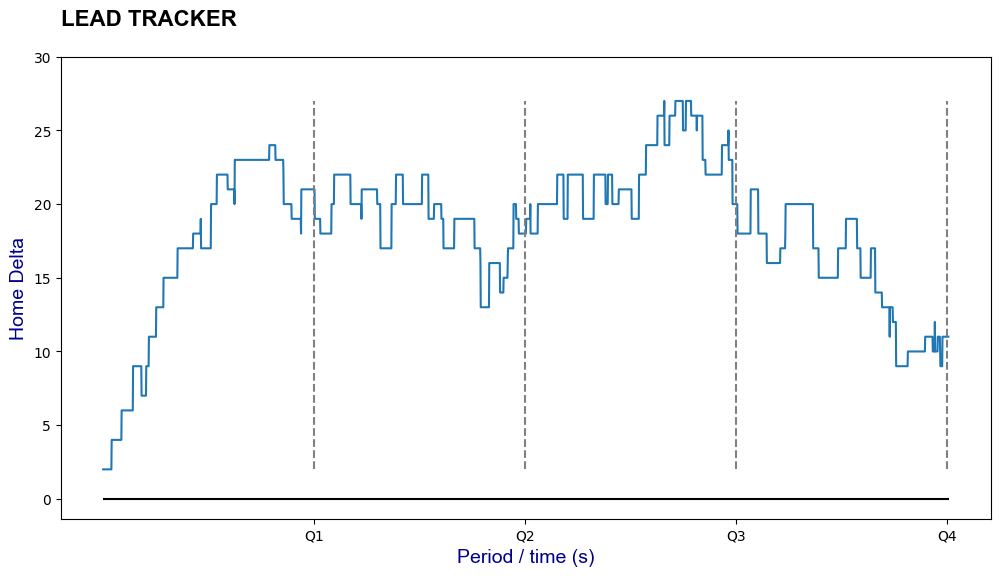

In [5]:
font = {'family': 'arial',
        'color':  'darkblue',
        'weight': 'normal',
        'size': 14,
        }

title_font = {'family': 'arial',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }


game_id = list((nba_games_id.sample(1)["GAME_ID"]))[0]
df = get_play_by_play(game_id)
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df['HomeDelta'])
ax.hlines(y=0,         xmin=0,      xmax=df.shape[0],       colors='black')
for period in range(1,5):
    ax.vlines(x=(60*12*period), 
              ymin=df['HomeDelta'].min(), 
              ymax=df['HomeDelta'].max(), 
              colors='gray',
              ls = '--'
              )
for period in range(5,(df['PERIOD'].max()+1)):
    ax.vlines(x=(60*5*period),
              ymin=df['HomeDelta'].min()//5, 
              ymax=df['HomeDelta'].max(), 
              colors='gray',
              ls = '--'
              )
y_ticks = np.arange(((df['HomeDelta'].min()//5))*5, ((df['HomeDelta'].max()//5)+2)*5, 5)
plt.yticks(y_ticks)

x_labels = [(12*60*1),(12*60*2),(12*60*3),(12*60*4)]
plt.xticks(x_labels,labels=['Q1','Q2','Q3','Q4'])
plt.title("LEAD TRACKER\n ",fontdict=title_font, loc='left')
plt.xlabel('Period / time (s)', fontdict=font)
plt.ylabel('Home Delta', fontdict=font)


In [16]:
df_dates = get_all_nba_games(2022)
df_dates.sort_values('GAME_DATE').reset_index(drop=True)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22022,1610612744,GSW,Golden State Warriors,0022200002,2022-10-18,GSW vs. LAL,W,240,45,...,37,48,31,11,4,18,23,123,14,1
1,22022,1610612738,BOS,Boston Celtics,0022200001,2022-10-18,BOS vs. PHI,W,240,46,...,30,36,24,8,3,11,24,126,9,1
2,22022,1610612751,BKN,Brooklyn Nets,0022200006,2022-10-19,BKN vs. NOP,L,240,40,...,30,39,22,10,10,16,25,108,-22,1
3,22022,1610612762,UTA,Utah Jazz,0022200012,2022-10-19,UTA vs. DEN,W,240,42,...,32,43,27,10,1,20,21,123,21,1
4,22022,1610612756,PHX,Phoenix Suns,0022200013,2022-10-19,PHX vs. DAL,W,240,40,...,32,40,25,4,5,12,29,107,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,42022,1610612743,DEN,Denver Nuggets,0042200401,2023-06-01,DEN vs. MIA,W,240,40,...,39,45,29,4,4,10,8,104,11,1
1310,42022,1610612743,DEN,Denver Nuggets,0042200402,2023-06-04,DEN vs. MIA,L,240,39,...,29,38,23,7,2,14,21,108,-3,1
1311,42022,1610612748,MIA,Miami Heat,0042200403,2023-06-07,MIA vs. DEN,L,240,34,...,23,33,20,7,3,4,22,94,-15,1
1312,42022,1610612748,MIA,Miami Heat,0042200404,2023-06-09,MIA vs. DEN,L,240,35,...,29,37,23,2,3,15,19,95,-13,1


In [375]:
from nba_api.stats.endpoints import boxscoretraditionalv2
import pandas as pd

# Replace 'your_game_id' with the actual GAME_ID you want to fetch
game_id = '0042200405'

# Use the boxscoretraditionalv2 endpoint to get the player statistics for the game
boxscore = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game_id)

# Convert the response to a DataFrame
boxscore_df = boxscore.get_data_frames()[0]
# boxscore_df
starting_lineup = list(boxscore_df.loc[boxscore_df['TEAM_ID']==1610612743][0:5]["PLAYER_ID"])


starting_lineup

[1629008, 203932, 203999, 203484, 1627750]

In [376]:
from nba_api.stats.endpoints import boxscoretraditionalv2
from nba_api.stats.endpoints import playbyplayv2
import pandas as pd

# Replace 'your_game_id' with the actual GAME_ID you want to fetch
game_id = '0042200405'

# Use the playbyplayv2 endpoint to get the play-by-play data for the game
playbyplay = playbyplayv2.PlayByPlayV2(game_id=game_id)

# Convert the response to a DataFrame
playbyplay_df = playbyplay.get_data_frames()[0]
print(playbyplay_df.columns)
playbyplay_df

Index(['GAME_ID', 'EVENTNUM', 'EVENTMSGTYPE', 'EVENTMSGACTIONTYPE', 'PERIOD',
       'WCTIMESTRING', 'PCTIMESTRING', 'HOMEDESCRIPTION', 'NEUTRALDESCRIPTION',
       'VISITORDESCRIPTION', 'SCORE', 'SCOREMARGIN', 'PERSON1TYPE',
       'PLAYER1_ID', 'PLAYER1_NAME', 'PLAYER1_TEAM_ID', 'PLAYER1_TEAM_CITY',
       'PLAYER1_TEAM_NICKNAME', 'PLAYER1_TEAM_ABBREVIATION', 'PERSON2TYPE',
       'PLAYER2_ID', 'PLAYER2_NAME', 'PLAYER2_TEAM_ID', 'PLAYER2_TEAM_CITY',
       'PLAYER2_TEAM_NICKNAME', 'PLAYER2_TEAM_ABBREVIATION', 'PERSON3TYPE',
       'PLAYER3_ID', 'PLAYER3_NAME', 'PLAYER3_TEAM_ID', 'PLAYER3_TEAM_CITY',
       'PLAYER3_TEAM_NICKNAME', 'PLAYER3_TEAM_ABBREVIATION',
       'VIDEO_AVAILABLE_FLAG'],
      dtype='object')


,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG
0,0042200405,2,12,0,1,8:39 PM,12:00,None,Start of 1st Period (8:39 PM EST),None,...,None,None,0,0,None,NaN,None,None,None,0
1,0042200405,4,10,0,1,8:39 PM,12:00,Jump Ball Jokic vs. Adebayo: Tip to Murray,None,None,...,Heat,MIA,4,1627750,Jamal Murray,1.610613e+09,Denver,Nuggets,DEN,1
2,0042200405,7,5,1,1,8:39 PM,11:43,Murray Bad Pass Turnover (P1.T1),None,Adebayo STEAL (1 STL),...,Heat,MIA,0,0,None,NaN,None,None,None,1
3,0042200405,9,1,50,1,8:39 PM,11:39,None,None,Adebayo 2' Running Dunk (2 PTS),...,None,None,0,0,None,NaN,None,None,None,1
4,0042200405,10,5,4,1,8:40 PM,11:28,Porter Jr. Traveling Turnover (P1.T2),None,None,...,None,None,1,0,None,NaN,None,None,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,0042200405,645,3,12,4,10:59 PM,0:14,Brown Free Throw 2 of 2 (10 PTS),None,None,...,None,None,0,0,None,NaN,None,None,None,1
459,0042200405,646,9,1,4,10:59 PM,0:14,None,None,Heat Timeout: Regular (Reg.7 Short 0),...,None,None,0,0,None,NaN,None,None,None,0
460,0042200405,647,2,1,4,11:01 PM,0:12,None,None,MISS Lowry 28' 3PT Jump Shot,...,None,None,0,0,None,NaN,None,None,None,1
461,0042200405,648,4,0,4,11:01 PM,0:09,Caldwell-Pope REBOUND (Off:1 Def:3),None,None,...,None,None,0,0,None,NaN,None,None,None,1


In [377]:
substitutions_log = playbyplay_df[playbyplay_df["HOMEDESCRIPTION"].str.contains('sub', case=False)&playbyplay_df["HOMEDESCRIPTION"].notna()]
substitutions_log[['PERIOD','PCTIMESTRING','HOMEDESCRIPTION','PLAYER1_ID','PLAYER1_NAME','PLAYER2_ID','PLAYER2_NAME']]

,PERIOD,PCTIMESTRING,HOMEDESCRIPTION,PLAYER1_ID,PLAYER1_NAME,PLAYER2_ID,PLAYER2_NAME
44,1,6:58,SUB: Green FOR Gordon,203932,Aaron Gordon,201145,Jeff Green
68,1,4:55,SUB: Brown FOR Murray,1627750,Jamal Murray,1628971,Bruce Brown
81,1,3:38,SUB: Braun FOR Porter Jr.,1629008,Michael Porter Jr.,1631128,Christian Braun
82,1,3:38,SUB: Murray FOR Caldwell-Pope,203484,Kentavious Caldwell-Pope,1627750,Jamal Murray
89,1,2:51,SUB: Porter Jr. FOR Jokic,203999,Nikola Jokic,1629008,Michael Porter Jr.
98,1,2:14,SUB: Jordan FOR Green,201145,Jeff Green,201599,DeAndre Jordan
132,2,11:13,SUB: Gordon FOR Jordan,201599,DeAndre Jordan,203932,Aaron Gordon
155,2,9:09,SUB: Caldwell-Pope FOR Murray,1627750,Jamal Murray,203484,Kentavious Caldwell-Pope
156,2,9:09,SUB: Jokic FOR Gordon,203932,Aaron Gordon,203999,Nikola Jokic
170,2,7:39,SUB: Murray FOR Porter Jr.,1629008,Michael Porter Jr.,1627750,Jamal Murray


In [378]:
starting_lineup.insert(0,1)
starting_lineup.insert(1,"12:00")
starting_lineup

[1, '12:00', 1629008, 203932, 203999, 203484, 1627750]

In [379]:
lineup_df = pd.DataFrame(columns=['PERIOD','PCTIMESTRING','PLAYER1','PLAYER2','PLAYER3','PLAYER4','PLAYER5'])
lineup_df.loc[len(lineup_df)] = starting_lineup
lineup_df

,PERIOD,PCTIMESTRING,PLAYER1,PLAYER2,PLAYER3,PLAYER4,PLAYER5
0,1,12:00,1629008,203932,203999,203484,1627750


In [380]:
substitutions_log['PCTIMESTRING'].values[0]

'6:58'

In [381]:
list(lineup_df.loc[len(lineup_df)-1].values)

[1, '12:00', 1629008, 203932, 203999, 203484, 1627750]

In [382]:
for i in range(0,len(substitutions_log)):
    PERIOD_SUB = substitutions_log['PERIOD'].values[i]
    PCTIMESTRING_SUB = substitutions_log['PCTIMESTRING'].values[i]
    player_out = substitutions_log['PLAYER1_ID'].values[i]
    player_in  = substitutions_log['PLAYER2_ID'].values[i]
    
    previous_lineup = list(lineup_df.loc[len(lineup_df)-1].values)
    new_lineup = previous_lineup
    new_lineup[0] = PERIOD_SUB
    new_lineup[1] = PCTIMESTRING_SUB
    new_lineup = [player_in if x == player_out else x for x in new_lineup]
    lineup_df.loc[i+1] = new_lineup

lineup_df

,PERIOD,PCTIMESTRING,PLAYER1,PLAYER2,PLAYER3,PLAYER4,PLAYER5
0,1,12:00,1629008,203932,203999,203484,1627750
1,1,6:58,1629008,201145,203999,203484,1627750
2,1,4:55,1629008,201145,203999,203484,1628971
3,1,3:38,1631128,201145,203999,203484,1628971
4,1,3:38,1631128,201145,203999,1627750,1628971
5,1,2:51,1631128,201145,1629008,1627750,1628971
6,1,2:14,1631128,201599,1629008,1627750,1628971
7,2,11:13,1631128,203932,1629008,1627750,1628971
8,2,9:09,1631128,203932,1629008,203484,1628971
9,2,9:09,1631128,203999,1629008,203484,1628971


In [383]:
idx = lineup_df.groupby(['PERIOD', 'PCTIMESTRING'])['PLAYER1'].idxmax()
clean_lineup_df = lineup_df.loc[idx].sort_index().reset_index(drop=True)
clean_lineup_df['PCTIMESTRING']= clean_lineup_df['PCTIMESTRING'].apply(lambda x: ':'.join(part.zfill(2) for part in x.split(':')))
clean_lineup_df

,PERIOD,PCTIMESTRING,PLAYER1,PLAYER2,PLAYER3,PLAYER4,PLAYER5
0,1,12:00,1629008,203932,203999,203484,1627750
1,1,06:58,1629008,201145,203999,203484,1627750
2,1,04:55,1629008,201145,203999,203484,1628971
3,1,03:38,1631128,201145,203999,203484,1628971
4,1,02:51,1631128,201145,1629008,1627750,1628971
5,1,02:14,1631128,201599,1629008,1627750,1628971
6,2,11:13,1631128,203932,1629008,1627750,1628971
7,2,09:09,1631128,203932,1629008,203484,1628971
8,2,07:39,1631128,203999,1627750,203484,1628971
9,2,02:13,1631128,203999,1629008,203484,1628971


In [384]:
home_lead_streak = get_play_by_play('0042200405')
home_lead_streak

(2884, 2)
(3017, 4)


/Users/eduardogarcia/Documents/GitHub/playbyplay/functions_pbp.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['HomeScore'] = merged_df['HomeScore'].fillna(method='bfill')
/Users/eduardogarcia/Documents/GitHub/playbyplay/functions_pbp.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['AwayScore'] = merged_df['AwayScore'].fillna(method='bfill')


,PERIOD,PCTIMESTRING,HomeDelta,TotalPoints
0,1,12:00,2.0,2.0
1,1,11:59,2.0,2.0
2,1,11:58,2.0,2.0
3,1,11:57,2.0,2.0
4,1,11:56,2.0,2.0
...,...,...,...,...
2879,4,00:04,-5.0,183.0
2880,4,00:03,-5.0,183.0
2881,4,00:02,-5.0,183.0
2882,4,00:01,-5.0,183.0


In [385]:
streak_lineup_df = home_lead_streak.merge(clean_lineup_df, how='left', on=['PERIOD','PCTIMESTRING'])
streak_lineup_df

,PERIOD,PCTIMESTRING,HomeDelta,TotalPoints,PLAYER1,PLAYER2,PLAYER3,PLAYER4,PLAYER5
0,1,12:00,2.0,2.0,1629008.0,203932.0,203999.0,203484.0,1627750.0
1,1,11:59,2.0,2.0,NaN,NaN,NaN,NaN,NaN
2,1,11:58,2.0,2.0,NaN,NaN,NaN,NaN,NaN
3,1,11:57,2.0,2.0,NaN,NaN,NaN,NaN,NaN
4,1,11:56,2.0,2.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2879,4,00:04,-5.0,183.0,NaN,NaN,NaN,NaN,NaN
2880,4,00:03,-5.0,183.0,NaN,NaN,NaN,NaN,NaN
2881,4,00:02,-5.0,183.0,NaN,NaN,NaN,NaN,NaN
2882,4,00:01,-5.0,183.0,NaN,NaN,NaN,NaN,NaN


In [386]:
columns_to_convert = streak_lineup_df.columns.values[-5:].tolist()
streak_lineup_df[columns_to_convert] = streak_lineup_df[columns_to_convert].fillna(method='ffill')

streak_lineup_df[columns_to_convert] = streak_lineup_df[columns_to_convert].astype('int')

streak_lineup_df['LineUp'] = streak_lineup_df[columns_to_convert].apply(lambda row: ', '.join(str(x) for x in sorted(row.dropna())), axis=1)

streak_lineup_df

/var/folders/mv/mkg__7515n9dswqmhcq_vz980000gn/T/ipykernel_89294/3484695608.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  streak_lineup_df[columns_to_convert] = streak_lineup_df[columns_to_convert].fillna(method='ffill')


,PERIOD,PCTIMESTRING,HomeDelta,TotalPoints,PLAYER1,PLAYER2,PLAYER3,PLAYER4,PLAYER5,LineUp
0,1,12:00,2.0,2.0,1629008,203932,203999,203484,1627750,"203484, 203932, 203999, 1627750, 1629008"
1,1,11:59,2.0,2.0,1629008,203932,203999,203484,1627750,"203484, 203932, 203999, 1627750, 1629008"
2,1,11:58,2.0,2.0,1629008,203932,203999,203484,1627750,"203484, 203932, 203999, 1627750, 1629008"
3,1,11:57,2.0,2.0,1629008,203932,203999,203484,1627750,"203484, 203932, 203999, 1627750, 1629008"
4,1,11:56,2.0,2.0,1629008,203932,203999,203484,1627750,"203484, 203932, 203999, 1627750, 1629008"
...,...,...,...,...,...,...,...,...,...,...
2879,4,00:04,-5.0,183.0,1628971,203999,203932,1627750,203484,"203484, 203932, 203999, 1627750, 1628971"
2880,4,00:03,-5.0,183.0,1628971,203999,203932,1627750,203484,"203484, 203932, 203999, 1627750, 1628971"
2881,4,00:02,-5.0,183.0,1628971,203999,203932,1627750,203484,"203484, 203932, 203999, 1627750, 1628971"
2882,4,00:01,-5.0,183.0,1628971,203999,203932,1627750,203484,"203484, 203932, 203999, 1627750, 1628971"


In [387]:
streak_lineup_df['HomeDif'] = streak_lineup_df['HomeDelta'].diff()
streak_lineup_df['HomeDif'].iloc[0] = streak_lineup_df['HomeDelta'].iloc[0]
streak_lineup_df

/var/folders/mv/mkg__7515n9dswqmhcq_vz980000gn/T/ipykernel_89294/3891778004.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streak_lineup_df['HomeDif'].iloc[0] = streak_lineup_df['HomeDelta'].iloc[0]


,PERIOD,PCTIMESTRING,HomeDelta,TotalPoints,PLAYER1,PLAYER2,PLAYER3,PLAYER4,PLAYER5,LineUp,HomeDif
0,1,12:00,2.0,2.0,1629008,203932,203999,203484,1627750,"203484, 203932, 203999, 1627750, 1629008",2.0
1,1,11:59,2.0,2.0,1629008,203932,203999,203484,1627750,"203484, 203932, 203999, 1627750, 1629008",0.0
2,1,11:58,2.0,2.0,1629008,203932,203999,203484,1627750,"203484, 203932, 203999, 1627750, 1629008",0.0
3,1,11:57,2.0,2.0,1629008,203932,203999,203484,1627750,"203484, 203932, 203999, 1627750, 1629008",0.0
4,1,11:56,2.0,2.0,1629008,203932,203999,203484,1627750,"203484, 203932, 203999, 1627750, 1629008",0.0
...,...,...,...,...,...,...,...,...,...,...,...
2879,4,00:04,-5.0,183.0,1628971,203999,203932,1627750,203484,"203484, 203932, 203999, 1627750, 1628971",0.0
2880,4,00:03,-5.0,183.0,1628971,203999,203932,1627750,203484,"203484, 203932, 203999, 1627750, 1628971",0.0
2881,4,00:02,-5.0,183.0,1628971,203999,203932,1627750,203484,"203484, 203932, 203999, 1627750, 1628971",0.0
2882,4,00:01,-5.0,183.0,1628971,203999,203932,1627750,203484,"203484, 203932, 203999, 1627750, 1628971",0.0


In [388]:
lineup_summary = pd.DataFrame(streak_lineup_df['LineUp'].unique(), columns=['LineUp'])
lineup_summary = lineup_summary.reset_index()
lineup_summary = lineup_summary.rename(columns={'index':'LineUp_Order'})
lineup_summary

,LineUp_Order,LineUp
0,0,"203484, 203932, 203999, 1627750, 1629008"
1,1,"201145, 203484, 203999, 1627750, 1629008"
2,2,"201145, 203484, 203999, 1628971, 1629008"
3,3,"201145, 203484, 203999, 1628971, 1631128"
4,4,"201145, 1627750, 1628971, 1629008, 1631128"
5,5,"201599, 1627750, 1628971, 1629008, 1631128"
6,6,"203932, 1627750, 1628971, 1629008, 1631128"
7,7,"203484, 203932, 1628971, 1629008, 1631128"
8,8,"203484, 203999, 1627750, 1628971, 1631128"
9,9,"203484, 203999, 1628971, 1629008, 1631128"


In [389]:
starting_lineup[2:]

[1629008, 203932, 203999, 203484, 1627750]

In [390]:
streak_lineup_df = streak_lineup_df.merge(lineup_summary[['LineUp','LineUp_Order']], on='LineUp')
streak_lineup_df = streak_lineup_df.reset_index()
streak_lineup_df = streak_lineup_df.rename(columns={'index':'seconds_in_game'})
streak_lineup_df['seconds_in_game'] = streak_lineup_df['seconds_in_game']+1
streak_lineup_df


# Create a new column to count the matching elements
streak_lineup_df['Starters_In_Lineup'] = streak_lineup_df[['PLAYER1', 'PLAYER2', 'PLAYER3', 'PLAYER4', 'PLAYER5']].apply(
    lambda row: sum(1 for element in row if element in starting_lineup[2:]), axis=1)

# Calculate the percentage of matching elements
streak_lineup_df['Starters_Percentage'] = (streak_lineup_df['Starters_In_Lineup'] /len(starting_lineup[2:]))
streak_lineup_df

,seconds_in_game,PERIOD,PCTIMESTRING,HomeDelta,TotalPoints,PLAYER1,PLAYER2,PLAYER3,PLAYER4,PLAYER5,LineUp,HomeDif,LineUp_Order,Starters_In_Lineup,Starters_Percentage
0,1,1,12:00,2.0,2.0,1629008,203932,203999,203484,1627750,"203484, 203932, 203999, 1627750, 1629008",2.0,0,5,1.0
1,2,1,11:59,2.0,2.0,1629008,203932,203999,203484,1627750,"203484, 203932, 203999, 1627750, 1629008",0.0,0,5,1.0
2,3,1,11:58,2.0,2.0,1629008,203932,203999,203484,1627750,"203484, 203932, 203999, 1627750, 1629008",0.0,0,5,1.0
3,4,1,11:57,2.0,2.0,1629008,203932,203999,203484,1627750,"203484, 203932, 203999, 1627750, 1629008",0.0,0,5,1.0
4,5,1,11:56,2.0,2.0,1629008,203932,203999,203484,1627750,"203484, 203932, 203999, 1627750, 1629008",0.0,0,5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2879,2880,4,00:04,-5.0,183.0,1628971,203999,203932,1627750,203484,"203484, 203932, 203999, 1627750, 1628971",0.0,13,4,0.8
2880,2881,4,00:03,-5.0,183.0,1628971,203999,203932,1627750,203484,"203484, 203932, 203999, 1627750, 1628971",0.0,13,4,0.8
2881,2882,4,00:02,-5.0,183.0,1628971,203999,203932,1627750,203484,"203484, 203932, 203999, 1627750, 1628971",0.0,13,4,0.8
2882,2883,4,00:01,-5.0,183.0,1628971,203999,203932,1627750,203484,"203484, 203932, 203999, 1627750, 1628971",0.0,13,4,0.8


In [391]:
x = streak_lineup_df['seconds_in_game']
y = streak_lineup_df['HomeDelta']
z = streak_lineup_df['Starters_In_Lineup']

print(x.shape, y.shape, z.shape)

(2884,) (2884,) (2884,)


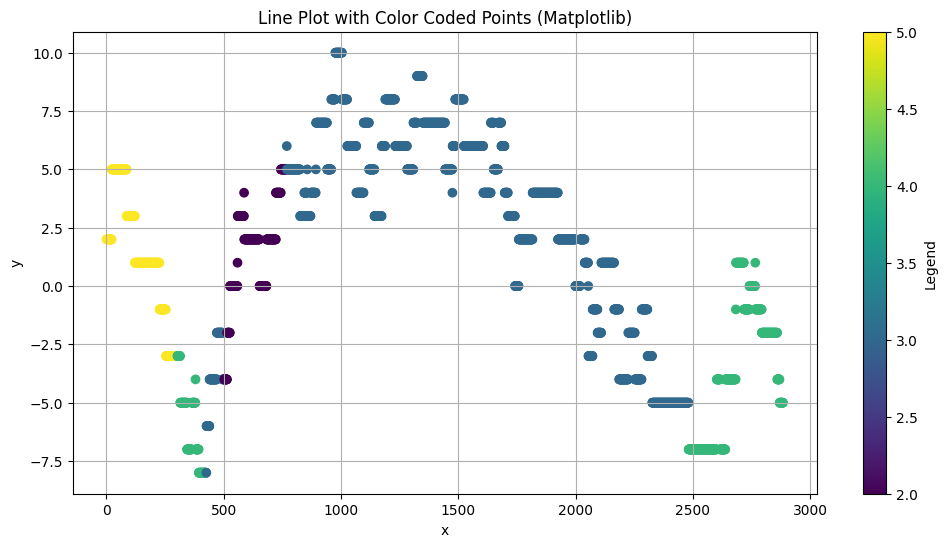

In [392]:
# Matplotlib version
plt.figure(figsize=(12, 6))
plt.scatter(x, y, c=z, cmap='viridis')
plt.colorbar(label='Legend')
plt.title('Line Plot with Color Coded Points (Matplotlib)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

/var/folders/mv/mkg__7515n9dswqmhcq_vz980000gn/T/ipykernel_89294/1066968077.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{int(y)}' for y in ax.get_yticks()])


KeyError: 0

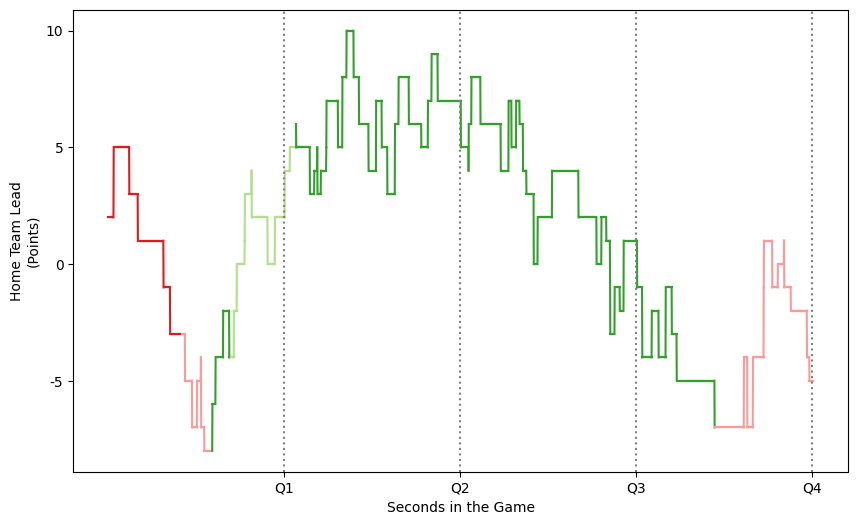

<Figure size 1000x600 with 0 Axes>

In [393]:
fig, ax = plt.subplots(figsize=(10, 6))

# Matplotlib plotting
plt.figure(figsize=(10, 6))

for i in range(len(streak_lineup_df) - 1):
    ax.plot(x[i:i+2], y[i:i+2], color=plt.cm.Paired(z[i]))

# Add vertical lines for each quarter
for quarter in range(1, 5):
    ax.axvline(x=12*60*quarter, color='gray', linestyle='dotted')

# Customize x-axis
ax.set_xticks([12*60*i for i in range(1, 5)])
ax.set_xticklabels([f'Q{i}' for i in range(1, 5)])

# Customize y-axis
ax.yaxis.set_major_locator(plt.MultipleLocator(5))
ax.set_yticklabels([f'{int(y)}' for y in ax.get_yticks()])

# Axis labels
ax.set_xlabel("Seconds in the Game")
ax.set_ylabel("Home Team Lead\n(Points)")

# Calculate counts and sums for the legend
legend_info = streak_lineup_df.groupby('Starters_In_Lineup')['HomeDif'].agg(['count', 'sum'])

# Add legend on the right side of the plot
for legend_value, color in enumerate(plt.cm.Paired.colors):
    count, sum_y = legend_info.loc[legend_value]
    ax.text(1.02, 0.95 - 0.1*legend_value, f'Legend {legend_value}: Count={count}, Sum={sum_y:.1f}', 
            transform=ax.transAxes, color=color, fontsize=9)

plt.show()

/var/folders/mv/mkg__7515n9dswqmhcq_vz980000gn/T/ipykernel_89294/3700193784.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{int(y_tick)}' for y_tick in ax.get_yticks()])


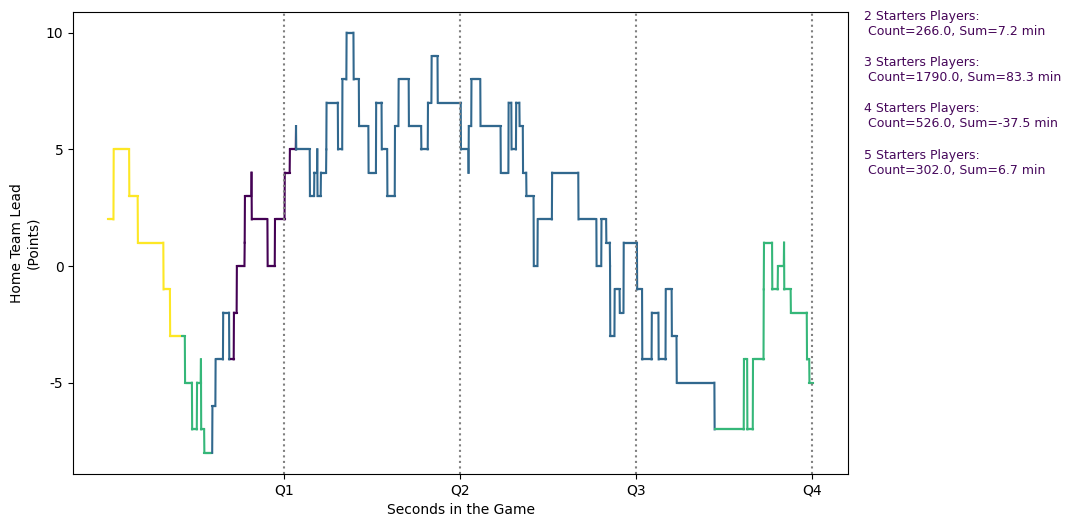

In [394]:
# Creating the DataFrame
df = pd.DataFrame({'x': x, 'y': y, 'z': z})

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Normalize 'z' values to map to a colormap
norm = plt.Normalize(df['z'].min(), df['z'].max())
colors = plt.cm.viridis(norm(df['z']))

# Plotting each segment in the DataFrame
for i in range(len(df) - 1):
    ax.plot(df['x'][i:i+2], df['y'][i:i+2], color=colors[i])

# Add vertical lines for each quarter
for quarter in range(1, 5):
    ax.axvline(x=12*60*quarter, color='gray', linestyle='dotted')

# Customize x-axis
ax.set_xticks([12*60*i for i in range(1, 5)])
ax.set_xticklabels([f'Q{i}' for i in range(1, 5)])

# Customize y-axis
ax.yaxis.set_major_locator(plt.MultipleLocator(5))
ax.set_yticklabels([f'{int(y_tick)}' for y_tick in ax.get_yticks()])

# Axis labels
ax.set_xlabel("Seconds in the Game")
ax.set_ylabel("Home Team Lead\n(Points)")

# # Add a colorbar for the 'z' values
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
# sm.set_array([])
# plt.colorbar(sm, ax=ax, label='# Starters in LineUp')

# Calculate counts and sums for the legend
legend_info = df.groupby('z')['y'].agg(['count', 'sum'])

# Add legend on the right side of the plot
for idx, (z_value, info) in enumerate(legend_info.iterrows()):
    ax.text(1.02, 0.95 - 0.1*idx, f'{z_value} Starters Players:\n Count={info["count"]}, Sum={info["sum"]/60:.1f} min', 
            transform=ax.transAxes, color=plt.cm.viridis(z_value), fontsize=9)


plt.show()


/var/folders/mv/mkg__7515n9dswqmhcq_vz980000gn/T/ipykernel_89294/3704029079.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{int(y_tick)}' for y_tick in ax.get_yticks()])


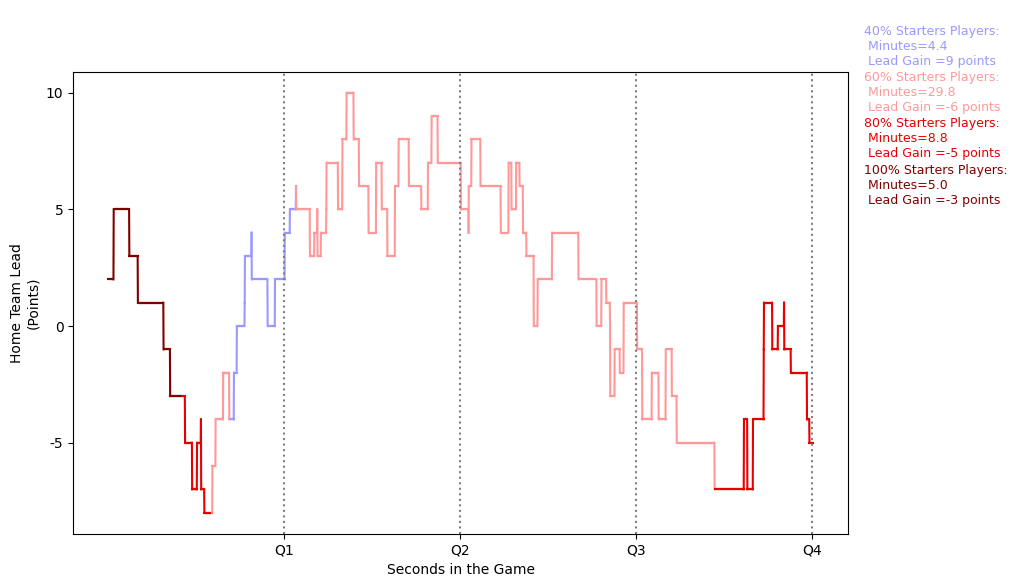

In [418]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the x, y, and z arrays
x = streak_lineup_df['seconds_in_game']
y = streak_lineup_df['HomeDelta']
z = streak_lineup_df['Starters_Percentage']
w = streak_lineup_df['HomeDif']

z_values = np.array([1, 0.8, 0.6, 0.4, 0.2, 0])  # Possible values for z

# Create DataFrame
df = pd.DataFrame({'x': x, 'y': y, 'z': z,'w':w})

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting each segment in the DataFrame
for i in range(len(df) - 1):
    ax.plot(df['x'][i:i+2], df['y'][i:i+2], color=plt.cm.seismic(df['z'][i]))

# Add vertical lines for each quarter
for quarter in range(1, 5):
    ax.axvline(x=12*60*quarter, color='gray', linestyle='dotted')

# Customize x-axis
ax.set_xticks([12*60*i for i in range(1, 5)])
ax.set_xticklabels([f'Q{i}' for i in range(1, 5)])

# Customize y-axis
ax.yaxis.set_major_locator(plt.MultipleLocator(5))
ax.set_yticklabels([f'{int(y_tick)}' for y_tick in ax.get_yticks()])

# Axis labels
ax.set_xlabel("Seconds in the Game")
ax.set_ylabel("Home Team Lead\n(Points)")

# Calculate counts and sums for the legend
legend_info = df.groupby('z')['w'].agg(['count', 'sum'])

# Add legend on the right side of the plot
for idx, (z_value, info) in enumerate(legend_info.iterrows()):
    ax.text(1.02, 0.95 - 0.1*idx, f'\n{z_value:.0%} Starters Players:\n Minutes={info["count"]/60:.1f}\n Lead Gain ={info["sum"]:.0f} points\n\n', 
            transform=ax.transAxes, color=plt.cm.seismic(z_value), fontsize=9)

plt.show()


In [1]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
from functions_pbp import get_play_by_play
from functions_pbp import create_home_delta_plot
from functions_pbp import get_all_nba_games
from nba_api.stats.endpoints import playbyplayv2
import numpy as np

In [11]:
play_by_play = playbyplayv2.PlayByPlayV2(game_id='0042200405')
play_by_play

In [12]:
# Extract the data to a DataFrame
play_by_play = play_by_play.get_data_frames()[0]
play_by_play

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG
0,0042200405,2,12,0,1,8:39 PM,12:00,None,Start of 1st Period (8:39 PM EST),None,...,None,None,0,0,None,NaN,None,None,None,0
1,0042200405,4,10,0,1,8:39 PM,12:00,Jump Ball Jokic vs. Adebayo: Tip to Murray,None,None,...,Heat,MIA,4,1627750,Jamal Murray,1.610613e+09,Denver,Nuggets,DEN,1
2,0042200405,7,5,1,1,8:39 PM,11:43,Murray Bad Pass Turnover (P1.T1),None,Adebayo STEAL (1 STL),...,Heat,MIA,0,0,None,NaN,None,None,None,1
3,0042200405,9,1,50,1,8:39 PM,11:39,None,None,Adebayo 2' Running Dunk (2 PTS),...,None,None,0,0,None,NaN,None,None,None,1
4,0042200405,10,5,4,1,8:40 PM,11:28,Porter Jr. Traveling Turnover (P1.T2),None,None,...,None,None,1,0,None,NaN,None,None,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,0042200405,645,3,12,4,10:59 PM,0:14,Brown Free Throw 2 of 2 (10 PTS),None,None,...,None,None,0,0,None,NaN,None,None,None,1
459,0042200405,646,9,1,4,10:59 PM,0:14,None,None,Heat Timeout: Regular (Reg.7 Short 0),...,None,None,0,0,None,NaN,None,None,None,0
460,0042200405,647,2,1,4,11:01 PM,0:12,None,None,MISS Lowry 28' 3PT Jump Shot,...,None,None,0,0,None,NaN,None,None,None,1
461,0042200405,648,4,0,4,11:01 PM,0:09,Caldwell-Pope REBOUND (Off:1 Def:3),None,None,...,None,None,0,0,None,NaN,None,None,None,1


In [21]:
play_by_play.columns

Index(['GAME_ID', 'EVENTNUM', 'EVENTMSGTYPE', 'EVENTMSGACTIONTYPE', 'PERIOD',
       'WCTIMESTRING', 'PCTIMESTRING', 'HOMEDESCRIPTION', 'NEUTRALDESCRIPTION',
       'VISITORDESCRIPTION', 'SCORE', 'SCOREMARGIN', 'PERSON1TYPE',
       'PLAYER1_ID', 'PLAYER1_NAME', 'PLAYER1_TEAM_ID', 'PLAYER1_TEAM_CITY',
       'PLAYER1_TEAM_NICKNAME', 'PLAYER1_TEAM_ABBREVIATION', 'PERSON2TYPE',
       'PLAYER2_ID', 'PLAYER2_NAME', 'PLAYER2_TEAM_ID', 'PLAYER2_TEAM_CITY',
       'PLAYER2_TEAM_NICKNAME', 'PLAYER2_TEAM_ABBREVIATION', 'PERSON3TYPE',
       'PLAYER3_ID', 'PLAYER3_NAME', 'PLAYER3_TEAM_ID', 'PLAYER3_TEAM_CITY',
       'PLAYER3_TEAM_NICKNAME', 'PLAYER3_TEAM_ABBREVIATION',
       'VIDEO_AVAILABLE_FLAG'],
      dtype='object')

In [13]:
play_by_play['EVENTMSGACTIONTYPE'].unique()

array([  0,   1,  50,   4, 102,  98,  47,   2,  76, 103,  26,  37,  45,
        80, 105,   6,  63,  58,  11,  12,   9,   3,  78,  75,  10,  52,
        74, 101,   5,  57,  73,  66,  41,  72,  97,  86,  99,  79,  39,
        96,   7,  67,  13,  14,  15,  28,  85])

In [22]:
play_by_play['EVENTMSGTYPE'].unique()

array([12, 10,  5,  1,  2,  4,  6,  9,  8,  3, 13,  7, 18])

In [32]:
play_by_play[['HOMEDESCRIPTION','VISITORDESCRIPTION','PERSON1TYPE']].head(20)

,HOMEDESCRIPTION,VISITORDESCRIPTION,PERSON1TYPE
0,None,None,0
1,Jump Ball Jokic vs. Adebayo: Tip to Murray,None,4
2,Murray Bad Pass Turnover (P1.T1),Adebayo STEAL (1 STL),4
3,None,Adebayo 2' Running Dunk (2 PTS),5
4,Porter Jr. Traveling Turnover (P1.T2),None,4
5,None,MISS Vincent 5' Driving Floating Bank Jump Shot,5
6,Jokic REBOUND (Off:0 Def:1),None,4
7,MISS Gordon 3' Cutting Layup Shot,None,4
8,None,Strus REBOUND (Off:0 Def:1),5
9,Caldwell-Pope BLOCK (1 BLK),MISS Butler 5' Turnaround Jump Shot,5


In [36]:
play_by_play = playbyplayv2.PlayByPlayV2(game_id=GAME_ID)
play_by_play = play_by_play.get_data_frames()[0]
play_by_play.columns

Index(['GAME_ID', 'EVENTNUM', 'EVENTMSGTYPE', 'EVENTMSGACTIONTYPE', 'PERIOD',
       'WCTIMESTRING', 'PCTIMESTRING', 'HOMEDESCRIPTION', 'NEUTRALDESCRIPTION',
       'VISITORDESCRIPTION', 'SCORE', 'SCOREMARGIN', 'PERSON1TYPE',
       'PLAYER1_ID', 'PLAYER1_NAME', 'PLAYER1_TEAM_ID', 'PLAYER1_TEAM_CITY',
       'PLAYER1_TEAM_NICKNAME', 'PLAYER1_TEAM_ABBREVIATION', 'PERSON2TYPE',
       'PLAYER2_ID', 'PLAYER2_NAME', 'PLAYER2_TEAM_ID', 'PLAYER2_TEAM_CITY',
       'PLAYER2_TEAM_NICKNAME', 'PLAYER2_TEAM_ABBREVIATION', 'PERSON3TYPE',
       'PLAYER3_ID', 'PLAYER3_NAME', 'PLAYER3_TEAM_ID', 'PLAYER3_TEAM_CITY',
       'PLAYER3_TEAM_NICKNAME', 'PLAYER3_TEAM_ABBREVIATION',
       'VIDEO_AVAILABLE_FLAG'],
      dtype='object')

In [39]:
play_by_play

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG
0,0022200001,2,12,0,1,7:36 PM,12:00,None,Start of 1st Period (7:36 PM EST),None,...,None,None,0,0,None,NaN,None,None,None,0
1,0022200001,4,10,0,1,7:36 PM,12:00,Jump Ball Horford vs. Embiid: Tip to Harris,None,None,...,76ers,PHI,5,202699,Tobias Harris,1.610613e+09,Philadelphia,76ers,PHI,1
2,0022200001,7,2,86,1,7:36 PM,11:38,Brown BLOCK (1 BLK),None,MISS Embiid 13' Turnaround Fadeaway Shot,...,None,None,4,1627759,Jaylen Brown,1.610613e+09,Boston,Celtics,BOS,1
3,0022200001,9,4,0,1,7:36 PM,11:35,None,None,Tucker REBOUND (Off:1 Def:0),...,None,None,0,0,None,NaN,None,None,None,1
4,0022200001,10,5,40,1,7:36 PM,11:35,None,None,Tucker Out of Bounds Lost Ball Turnover (P1.T1),...,None,None,1,0,None,NaN,None,None,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,0022200001,637,5,2,4,10:07 PM,0:32,Brown Lost Ball Turnover (P4.T11),None,Harris STEAL (3 STL),...,76ers,PHI,0,0,None,NaN,None,None,None,1
442,0022200001,639,1,50,4,10:07 PM,0:29,None,None,Harris 1' Running Dunk (18 PTS),...,None,None,0,0,None,NaN,None,None,None,1
443,0022200001,640,2,1,4,10:07 PM,0:06,MISS Horford 25' 3PT Jump Shot,None,None,...,None,None,0,0,None,NaN,None,None,None,1
444,0022200001,641,4,0,4,10:07 PM,0:04,None,None,Harden REBOUND (Off:0 Def:8),...,None,None,0,0,None,NaN,None,None,None,1


In [38]:
play_by_play[['PERIOD','PCTIMESTRING','HOMEDESCRIPTION','NEUTRALDESCRIPTION','VISITORDESCRIPTION','PLAYER1_NAME','PLAYER2_NAME','PLAYER3_NAME']].to_excel('Homedescription.xlsx')

In [40]:
df

,GAME_ID,GAME_DATE,MATCHUP,HOMETEAM_ID,AWAYTEAM_ID
168,0022200001,2022-10-18,BOS vs. PHI,1610612738,1610612755
170,0022200002,2022-10-18,GSW vs. LAL,1610612744,1610612747
195,0022200003,2022-10-19,DET vs. ORL,1610612765,1610612753
184,0022200004,2022-10-19,IND vs. WAS,1610612754,1610612764
192,0022200005,2022-10-19,ATL vs. HOU,1610612737,1610612745
...,...,...,...,...,...
158,0042200401,2023-06-01,DEN vs. MIA,1610612743,1610612748
160,0042200402,2023-06-04,DEN vs. MIA,1610612743,1610612748
163,0042200403,2023-06-07,MIA vs. DEN,1610612748,1610612743
164,0042200404,2023-06-09,MIA vs. DEN,1610612748,1610612743
